# 3D Quadcopter Navigation with Verification-in-the-Loop Training

A verification-integrated approach to learning control policies with formal safety guarantees.

**Key Concepts:**

**1. Differentiable Reachability Analysis**
For each time step, we compute reachable sets R_t=[l_t,u_t] where:
- l_t is a lower bound vector of state variables
- u_t is an upper bound vector of state variables
- CROWN algorithm provides differentiable bounds w.r.t. controller parameters

**2. Specialized Loss Function Components**
L = L_goal + L_obstacle + L_vol + L_vel
- L_goal: Drives system toward goal region
- L_obstacle: Penalizes overlap with obstacles
- L_vol: Encourages tight verification bounds
- L_vel: Stabilizes velocities near goal

**3. Verification-in-the-Loop Training**
- Performs verification during each training iteration
- Loss incorporates safety specifications and bound tightness
- Results in controller with guaranteed safe behavior

**4. Quadcopter Physics Model**
- 6D state space (position and velocity)
- Realistic drag forces proportional to squared velocity
- Cross-coupling effects between dimensions

In [1]:
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git@newer-jax-verify

  Cloning https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git (to revision newer-jax-verify) to /tmp/pip-req-build-4flsu4l9
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git /tmp/pip-req-build-4flsu4l9
  Running command git checkout -b newer-jax-verify --track origin/newer-jax-verify
  Switched to a new branch 'newer-jax-verify'
  Branch 'newer-jax-verify' set up to track remote branch 'newer-jax-verify' from 'origin'.
  Resolved https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git to commit e3128f4da97353ade04bb5637277339d41687461
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/deepmind/einshape.git to /tmp/pip-install-azdyw616/einshape_b3da9c2a8733405484c95ef0e9c8e8a0
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/einshape.git /tmp/pip-install-azdyw616/einshape_b3da9c2a8733405484c95ef0e9c8e8a0
  Resolved https://github.com/d

In [2]:
import jax
import jax.numpy as jnp
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import jax_verify
import functools
import optax
from jax import grad, jit
import time
import plotly.graph_objects as go

# Neural Network Controller


In [3]:
def relu_nn(params, inputs, a_max=5.0):
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    Wout, bout = params[-1]
    outputs = jnp.dot(inputs, Wout) + bout
    ax = jnp.clip(outputs[0], -a_max, a_max)
    ay = jnp.clip(outputs[1], -a_max, a_max)
    az = jnp.clip(outputs[2], -a_max, a_max)
    return jnp.array([ax, ay, az])

def init_network_params(layer_sizes, rng_key):
    params = []
    for i in range(1, len(layer_sizes)):
        in_dim = layer_sizes[i - 1]
        out_dim = layer_sizes[i]
        key, rng_key = jax.random.split(rng_key)
        bound = jnp.sqrt(6.0 / (in_dim + out_dim))
        weights = jax.random.uniform(key, (in_dim, out_dim), minval=-bound, maxval=bound)
        biases = jnp.zeros(out_dim)
        params.append((weights, biases))
    return params

# Nonlinear Double Integrator Model

In [4]:
class NonlinearDoubleIntegratorModel:
    def __init__(self):
        self.delta_t = 0.4
        self.drag_coeff = 0.01
        self.coupling_coeff = 0.005

    def dynamics_step(self, xs, ut):
        # State: [x, y, z, vx, vy, vz]
        # Control: [ax, ay, az]
        x, y, z, vx, vy, vz = xs
        ax, ay, az = ut

        drag_x = -self.drag_coeff * vx * jnp.abs(vx)
        drag_y = -self.drag_coeff * vy * jnp.abs(vy)
        drag_z = -self.drag_coeff * vz * jnp.abs(vz)

        coupling_x = self.coupling_coeff * vy * vz
        coupling_y = self.coupling_coeff * vx * vz
        coupling_z = self.coupling_coeff * vx * vy

        vx_new = vx + (ax + drag_x + coupling_x) * self.delta_t
        vy_new = vy + (ay + drag_y + coupling_y) * self.delta_t
        vz_new = vz + (az + drag_z + coupling_z) * self.delta_t

        x_new = x + vx * self.delta_t + 0.5 * (ax + drag_x + coupling_x) * self.delta_t**2
        y_new = y + vy * self.delta_t + 0.5 * (ay + drag_y + coupling_y) * self.delta_t**2
        z_new = z + vz * self.delta_t + 0.5 * (az + drag_z + coupling_z) * self.delta_t**2

        max_val = 1e6
        return jnp.clip(
            jnp.array([x_new, y_new, z_new, vx_new, vy_new, vz_new]),
            -max_val, max_val
        )

# Loss Functions

In [5]:
def loss_multi_step_reachable_set_volume(reachable_sets):
    volumes = [jnp.prod(set_.upper[:3] - set_.lower[:3]) for set_ in reachable_sets]
    initial_volume = volumes[0]
    volume_penalty = 0.0

    for i in range(1, len(volumes)):
        relative_deviation = jnp.abs(volumes[i] - initial_volume) / initial_volume
        volume_penalty += 10.0 * relative_deviation

    return volume_penalty

def loss_reach_goal_with_obstacles(controller_params, initial_state_bounds, goal_point, num_steps, obstacles):
    reachable_set = compute_multistep_reachable_set(
        initial_state_bounds,
        functools.partial(step_1),
        controller_params,
        num_steps
    )

    loss_value = 0.0
    volume_loss = loss_multi_step_reachable_set_volume(reachable_set)

    for i, state_bounds in enumerate(reachable_set):
        state_center = (state_bounds.upper + state_bounds.lower) / 2
        eps = 1e-6

        distance_to_goal = jnp.sum((state_center[:3] - goal_point)**2)
        distance_to_goal = jnp.sqrt(distance_to_goal + eps)

        overlap_lower = jnp.maximum(state_bounds.lower[:3], goal_point - 0.5)
        overlap_upper = jnp.minimum(state_bounds.upper[:3], goal_point + 0.5)
        overlap_width = jnp.maximum(overlap_upper - overlap_lower, 0)
        overlap_volume = jnp.prod(overlap_width + eps)

        velocity_penalty = 0.05 * (jnp.sum(jnp.abs(state_bounds.upper[3:6])) +
                                 jnp.sum(jnp.abs(state_bounds.lower[3:6])))

        obstacle_penalty = 0.0
        for obstacle in obstacles:
            center = obstacle[:3]
            radius = obstacle[3]

            center_array = jnp.array(center)
            closest_point = jnp.maximum(state_bounds.lower[:3], jnp.minimum(center_array, state_bounds.upper[:3]))

            dist_to_obstacle = jnp.sqrt(jnp.sum((closest_point - center)**2) + eps)

            penetration = jnp.maximum(0.0, radius - dist_to_obstacle)
            obstacle_penalty += 500.0 * penetration**2

            safety_margin = 1.0
            proximity = jnp.maximum(0.0, radius + safety_margin - dist_to_obstacle)

            proximity_penalty = 100.0 * proximity**2
            obstacle_penalty += proximity_penalty

        distance_weight = 80.0
        overlap_weight = 50.0

        step_loss = distance_weight * distance_to_goal - overlap_weight * overlap_volume + velocity_penalty + obstacle_penalty
        loss_value += step_loss

    return loss_value + 4 * volume_loss

# Reachable Set Computation

In [6]:
def step_1(xt, params):
    ut = relu_nn(params, xt)
    return dyn.dynamics_step(xt, ut)

def compute_multistep_reachable_set(initial_state_range, step_fn, params, num_steps):
    initial_state_bounds = jax_verify.IntervalBound(initial_state_range[:, 0], initial_state_range[:, 1])
    state_bounds = initial_state_bounds
    state_ranges = [state_bounds]

    for i in range(num_steps):
        next_state_bounds = jax_verify.backward_crown_bound_propagation(
            functools.partial(step_fn, params=params), state_bounds)
        state_ranges.append(next_state_bounds)
        state_bounds = next_state_bounds

    return state_ranges

# Controller Training

In [7]:
def train_controller_with_obstacles(params, optimizer, initial_state_range, num_epochs, goal_point, num_steps, obstacles,
                                   patience=100, threshold=1e-7):
    opt_state = optimizer.init(params)
    best_loss = float('inf')
    best_params = params
    epochs_without_improvement = 0
    loss_history = []

    @jax.jit
    def train_step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss_reach_goal_with_obstacles)(
            params, initial_state_range, goal_point, num_steps, obstacles)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(num_epochs):
        params, opt_state, loss_value = train_step(params, opt_state)
        loss_history.append(loss_value)

        if loss_value < best_loss:
            best_loss = loss_value
            best_params = params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_value}")

        if epochs_without_improvement >= patience:
            if abs(best_loss - loss_value) < threshold:
                print(f"Loss plateaued. Stopping training at epoch {epoch}.")
                break

    return best_params, loss_history

# Visualization Functions

In [8]:
def check_obstacle_overlap(bounds, obstacles):
    for i, obstacle in enumerate(obstacles):
        center = np.array(obstacle[:3])
        radius = float(obstacle[3])

        lower = np.array(bounds.lower[:3])
        upper = np.array(bounds.upper[:3])

        closest_point = np.maximum(lower, np.minimum(center, upper))

        dist_to_obstacle = np.sqrt(np.sum((closest_point - center)**2))

        if dist_to_obstacle < radius:
            return True, i

    return False, -1

def plot_3d_reachable_sets_with_obstacles(initial_state_range, step_fn, num_steps, goal_point, obstacles, bounds_list=None):
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000, 6))
    states = [xt]
    for i in range(num_steps):
        xt1 = jax.vmap(step_fn)(xt)
        states.append(xt1)
        xt = xt1

    colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
    ]
    while len(colors) < len(states):
        colors += colors

    fig = go.Figure()

    for i, obstacle in enumerate(obstacles):
        center = np.array(obstacle[:3])
        radius = float(obstacle[3])

        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = center[0] + radius * np.cos(u) * np.sin(v)
        y = center[1] + radius * np.sin(u) * np.sin(v)
        z = center[2] + radius * np.cos(v)

        fig.add_trace(go.Surface(
            x=x, y=y, z=z,
            colorscale=[[0, 'red'], [1, 'red']],
            opacity=0.5,
            showscale=False,
            name=f'Obstacle {i+1}'
        ))

    for i, state in enumerate(states):
        fig.add_trace(go.Scatter3d(
            x=state[:, 0], y=state[:, 1], z=state[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                opacity=0.5,
                color=colors[i % len(colors)]
            ),
            name=f'Step {i}'
        ))

    if bounds_list is not None:
        print("\nReachable Set Analysis:")
        for i, bounds in enumerate(bounds_list):
            lower = bounds.lower[:3]
            upper = bounds.upper[:3]
            volume = np.prod(upper - lower)

            overlap, obstacle_idx = check_obstacle_overlap(bounds, obstacles)
            overlap_status = "⚠️ OVERLAPS WITH OBSTACLE " + str(obstacle_idx) if overlap else "✓ No obstacle overlap"

            print(f"Step {i}:")
            print(f"     Status: {overlap_status}")

            x = [lower[0], upper[0]]
            y = [lower[1], upper[1]]
            z = [lower[2], upper[2]]

            line_color = 'red' if overlap else 'black'
            line_width = 3 if overlap else 2

            for j in [0, 1]:
                for k in [0, 1]:
                    fig.add_trace(go.Scatter3d(
                        x=[x[0], x[1]], y=[y[j], y[j]], z=[z[k], z[k]],
                        mode='lines',
                        line=dict(color=line_color, width=line_width),
                        name='Bounds'
                    ))
                    fig.add_trace(go.Scatter3d(
                        x=[x[j], x[j]], y=[y[0], y[1]], z=[z[k], z[k]],
                        mode='lines',
                        line=dict(color=line_color, width=line_width),
                        name='Bounds'
                    ))
                    fig.add_trace(go.Scatter3d(
                        x=[x[j], x[j]], y=[y[k], y[k]], z=[z[0], z[1]],
                        mode='lines',
                        line=dict(color=line_color, width=line_width),
                        name='Bounds'
                    ))

    start_center = [(initial_state_range[i][0] + initial_state_range[i][1]) / 2 for i in range(3)]
    fig.add_trace(go.Scatter3d(
        x=[start_center[0]], y=[start_center[1]], z=[start_center[2]],
        mode='markers',
        marker=dict(size=8, color='blue'),
        name='Start'
    ))

    fig.add_trace(go.Scatter3d(
        x=[goal_point[0]], y=[goal_point[1]], z=[goal_point[2]],
        mode='markers',
        marker=dict(size=30, color='green'),
        name='Goal'
    ))

    fig.update_layout(
        title='3D Reachable Sets with Obstacles',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        width=700,
        height=700,
        legend=dict(
            itemsizing='constant'
        )
    )

    fig.show()

# Run the Experiment

Starting training with obstacle avoidance...
Epoch 0, Loss: 1.6064650619204848e+22
Epoch 100, Loss: 99406.59375
Epoch 200, Loss: 4702.64697265625
Epoch 300, Loss: 3671.24560546875
Epoch 400, Loss: 3048.226318359375
Epoch 500, Loss: 2853.599853515625
Epoch 600, Loss: 2843.833984375
Epoch 700, Loss: 2714.06103515625
Epoch 800, Loss: 2619.19970703125
Epoch 900, Loss: 2544.595703125
Epoch 1000, Loss: 2635.5966796875
Epoch 1100, Loss: 2419.07177734375
Epoch 1200, Loss: 2512.32958984375
Epoch 1300, Loss: 2457.013916015625
Epoch 1400, Loss: 2453.58349609375
Epoch 1500, Loss: 2522.8486328125
Epoch 1600, Loss: 2446.72216796875
Epoch 1700, Loss: 2454.31689453125
Epoch 1800, Loss: 2475.19482421875
Epoch 1900, Loss: 2473.60888671875
Epoch 2000, Loss: 2402.322998046875
Epoch 2100, Loss: 2367.63720703125
Epoch 2200, Loss: 2382.2646484375
Epoch 2300, Loss: 2379.48876953125
Epoch 2400, Loss: 2366.3955078125
Epoch 2500, Loss: 2368.887939453125
Epoch 2600, Loss: 2368.769775390625
Epoch 2700, Loss: 2364.

Plotting loss history...


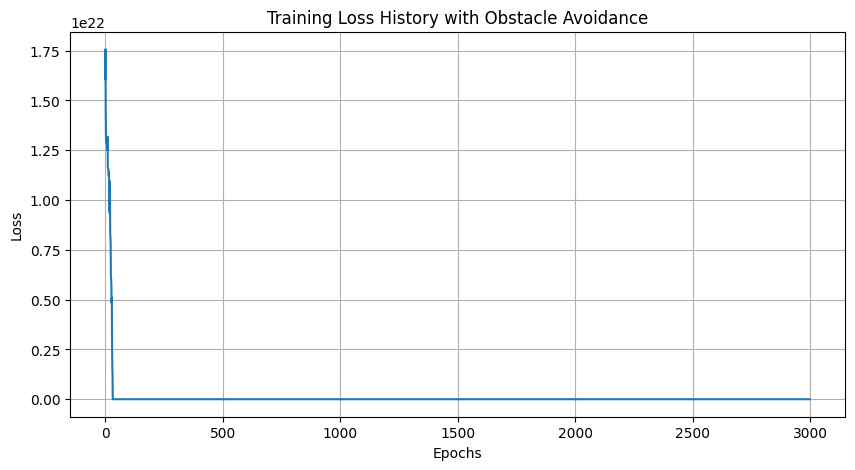

In [9]:
if __name__ == "__main__":
    initial_state_range = np.array([
        [0, 1],      # x position
        [0, 1],      # y position
        [0, 1],      # z position
        [-0.5, 0.5], # x velocity
        [-0.5, 0.5], # y velocity
        [-0.5, 0.5]  # z velocity
    ])

    goal_point = np.array([3, 3, 3])

    num_steps = 20
    learning_rate = 0.003
    optimizer = optax.chain(
        optax.clip(1.0),
        optax.adam(learning_rate),
        optax.scale_by_schedule(
            lambda step: jnp.where(
                step < 1000,
                1.0,
                jnp.where(step < 2000, 0.5, 0.1)
            )
        )
    )

    num_epochs = 3000
    layer_sizes = [6, 24, 48, 24, 3]

    # Define obstacles
    obstacles = [
        jnp.array([2.5, 1.5, 1.0, 0.5]),  # Obstacle 1 in the middle of the path
        jnp.array([3.0, 4.0, 3.0, 0.3])   # Obstacle 2 near the goal
    ]

    dyn = NonlinearDoubleIntegratorModel()

    rng_key = jax.random.PRNGKey(1)
    params = init_network_params(layer_sizes, rng_key)

    print("Starting training with obstacle avoidance...")
    trained_params, loss_history = train_controller_with_obstacles(
        params, optimizer, jnp.array(initial_state_range), num_epochs, goal_point, num_steps, obstacles)
    print("Training completed.")

    print("Computing reachable sets using trained controller...")
    output_ranges = compute_multistep_reachable_set(
        initial_state_range, step_1, trained_params, num_steps)

    plot_3d_reachable_sets_with_obstacles(
        initial_state_range, functools.partial(step_1, params=trained_params),
        num_steps, goal_point, obstacles, bounds_list=output_ranges)

    print("Plotting loss history...")
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss History with Obstacle Avoidance')
    plt.grid(True)
    plt.show()